In [29]:
!pip install grad-cam
!pip install torcheval
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.0 MB/s eta 0:00:00


In [30]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from IPython.display import display
from torcheval.metrics.functional import binary_auprc
from torchmetrics import PrecisionRecallCurve
     

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [31]:
model_ft = torch.load("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/models/97%BBMalariaMobileNetV3.pt")
model_ft.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [32]:
malariadata = []
for filename in os.listdir("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/train/Malaria"):
  if filename.endswith("png") or filename.endswith("jpg"):
    malariadata.append((filename, "train"))
for filename in os.listdir("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/val/Malaria"):
  if filename.endswith("png") or filename.endswith("jpg"):
    malariadata.append((filename,"val"))

In [33]:
print(len(malariadata))

1148


malariadata = [(img_name, train), (image_name, train), (image_name, val)]

[imagename, imagename, imagename]

In [34]:
malaria_data_in_malaria_sam = []
for filename in os.listdir("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/malaria_SAM"):
  for i in malariadata:
    if filename == i[0]:
      malaria_data_in_malaria_sam.append((filename,i[1]))



In [35]:
print(len(malaria_data_in_malaria_sam))

919


In [43]:

def auc_judd(gt, pred):

    gt_binary = np.where(gt >= 0.5, 1, gt)
    gt_binary = np.where(gt_binary < 0.5, 0.0, gt_binary)
    
    thresholds = []

    for i in range(0, gt_binary.shape[0]):
        for j in range(0, gt_binary.shape[1]):
            if gt_binary[i][j] > 0.5:
                thresholds.append(pred[i][j])
    
    num_fixations = len(thresholds)
    area = []
    area.append((0.0, 0.0))


    for thresh in thresholds:
        temp = np.zeros(pred.shape)
        temp[pred >= thresh] = 1

        #print("Temp: ", np.add(temp, gt_binary))

        num_overlap = np.where(np.add(temp, gt_binary) == 2)[0].shape[0]
        tp = num_overlap/num_fixations

        fp = (np.sum(temp) - num_overlap)/((np.shape(gt_binary)[0] * np.shape(gt_binary)[1]) - num_fixations)

        area.append((round(fp, 4), round(tp, 4)))

    
    area.append((1.0, 1.0))



    area.sort(key = lambda x:x[0])
    tp_list = [x[1] for x in area]
    fp_list = [x[0] for x in area]

    print("AUC Judd: ", np.trapz(np.array(tp_list), np.array(fp_list)))

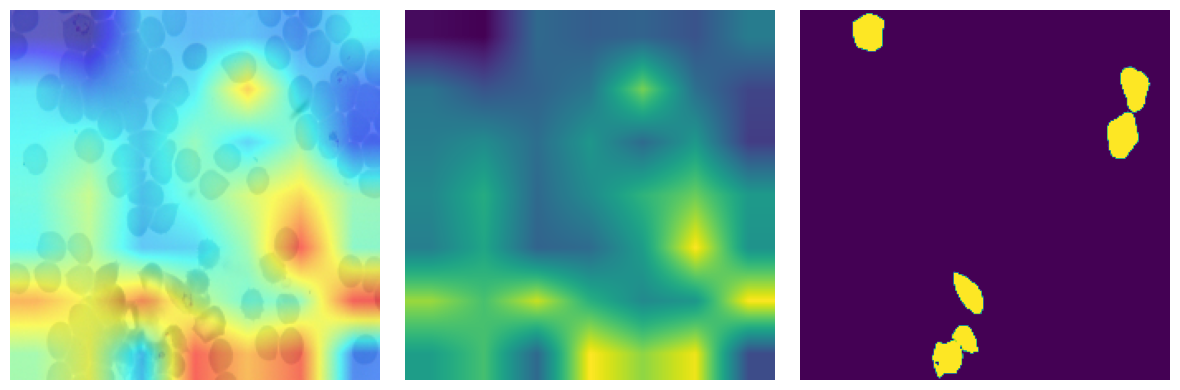

AUC Judd:  0.34608763
AUPRC:0.029305923730134964


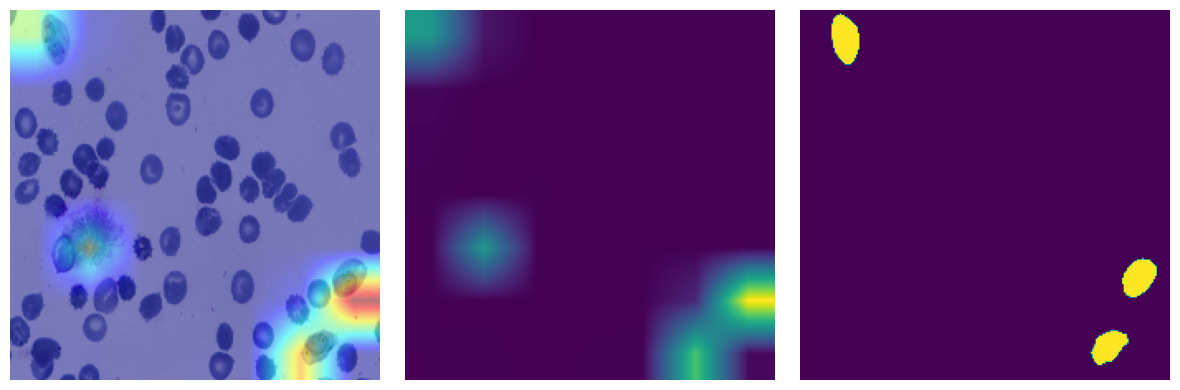

AUC Judd:  0.9538503299999999
AUPRC:0.1807660013437271


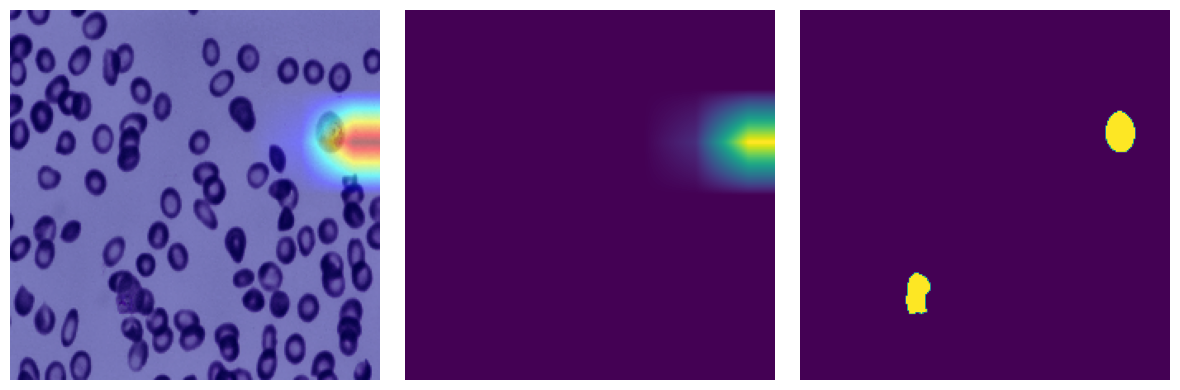

AUC Judd:  0.61947739
AUPRC:0.09796935319900513


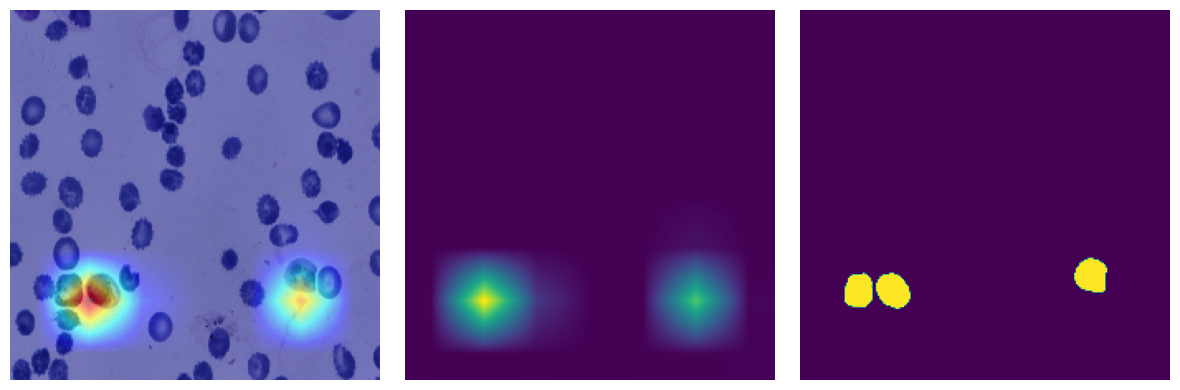

AUC Judd:  0.98279507
AUPRC:0.4256797134876251


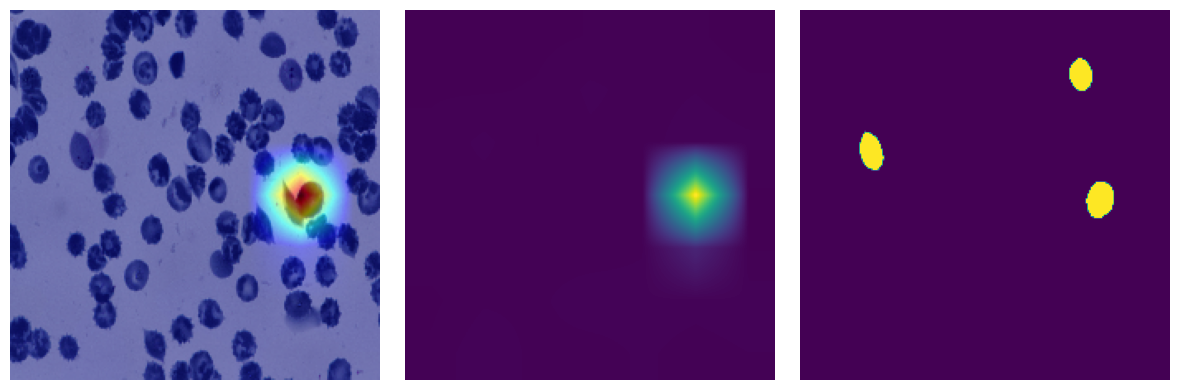

AUC Judd:  0.7805974499999999
AUPRC:0.251413494348526


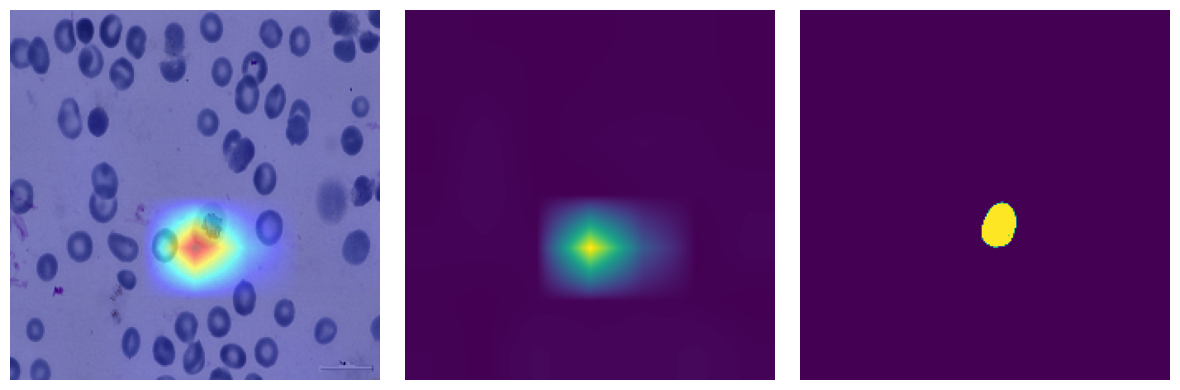

AUC Judd:  0.9826156300000001
AUPRC:0.22816401720046997


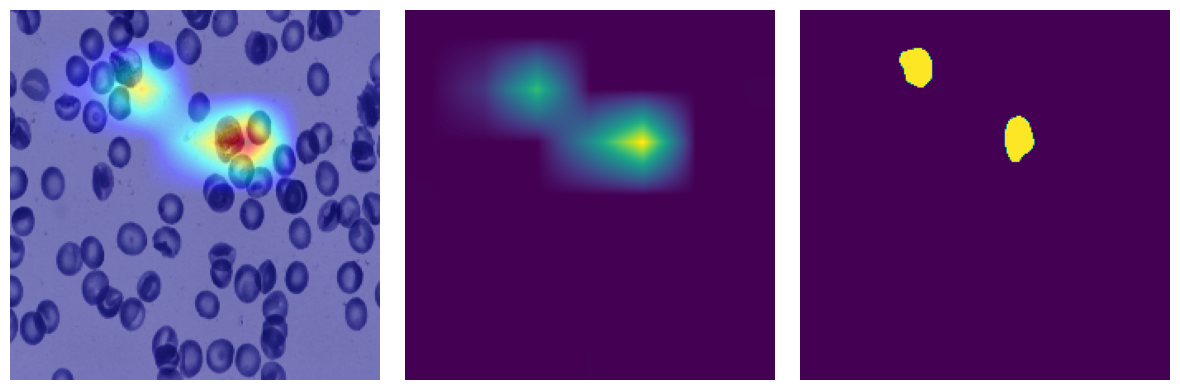

AUC Judd:  0.968962135
AUPRC:0.29893365502357483


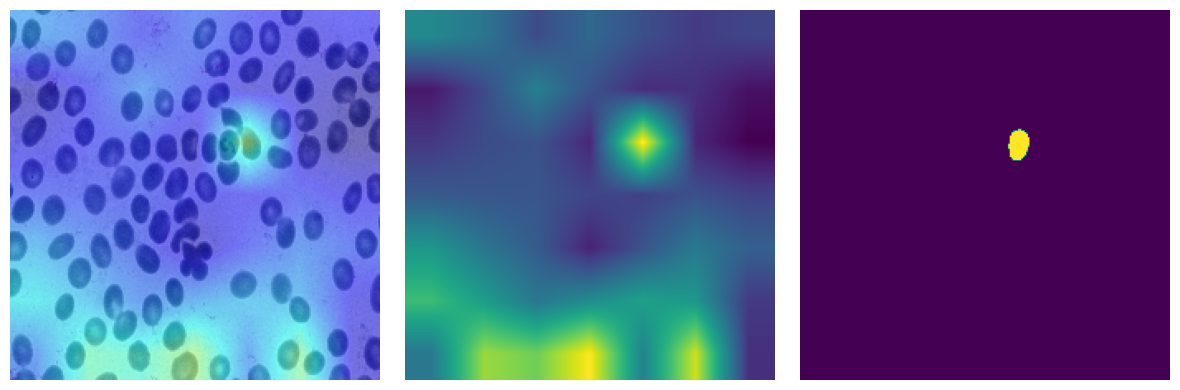

AUC Judd:  0.87934087
AUPRC:0.01440060418099165


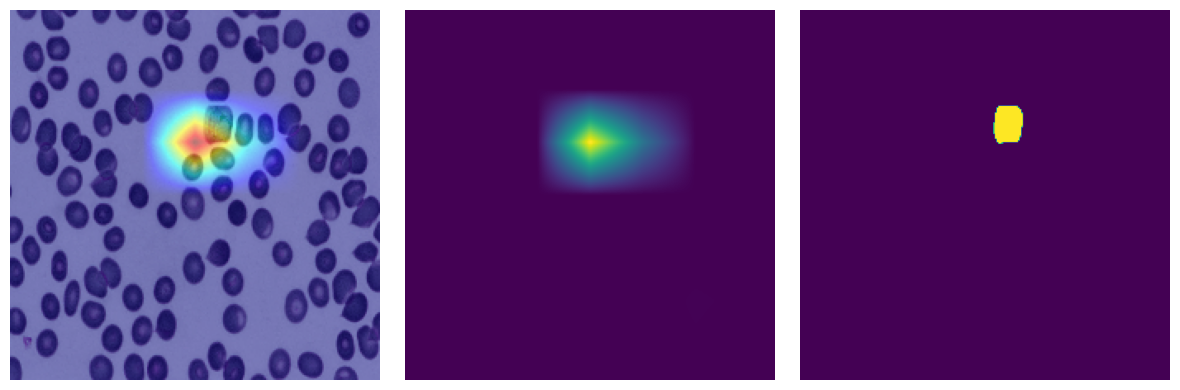

AUC Judd:  0.98281981
AUPRC:0.16865719854831696


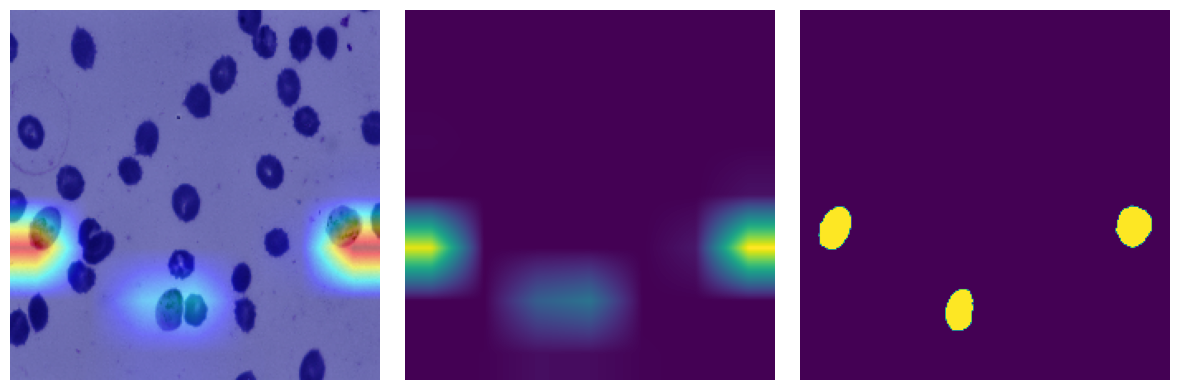

AUC Judd:  0.9613379300000001
AUPRC:0.22111541032791138


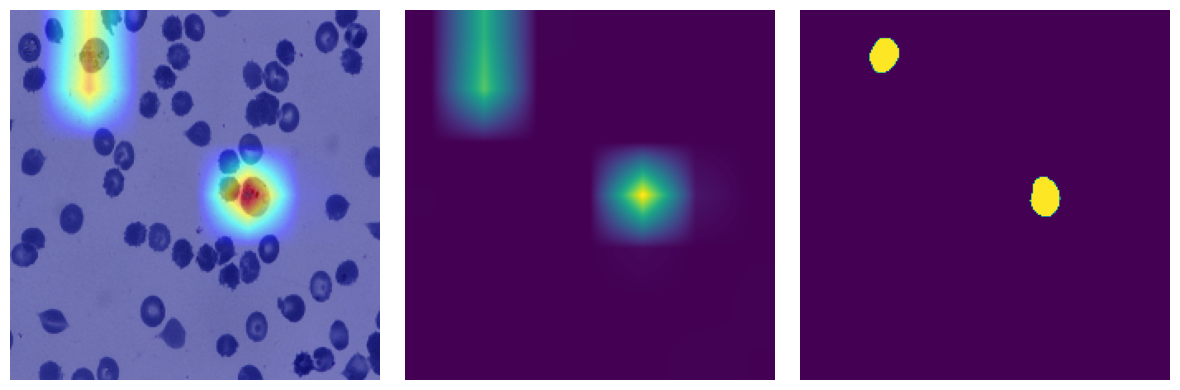

AUC Judd:  0.99329064
AUPRC:0.6381298899650574


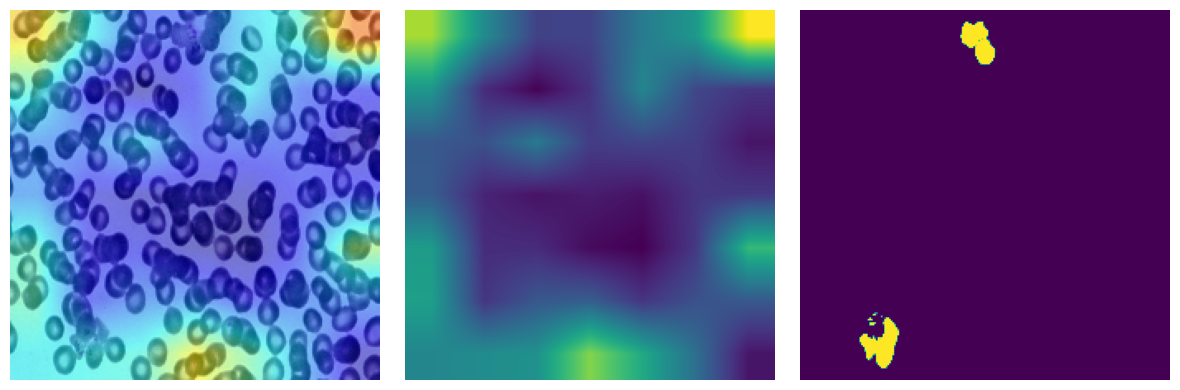

AUC Judd:  0.578364985
AUPRC:0.016522955149412155


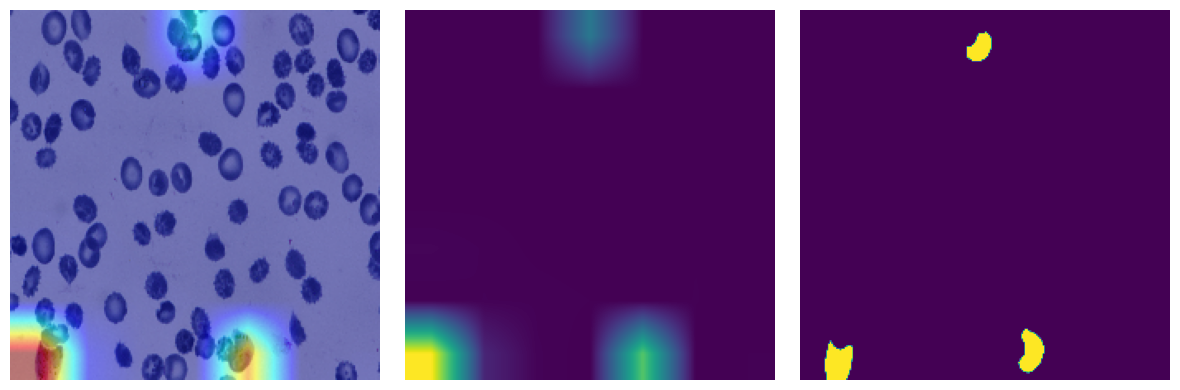

AUC Judd:  0.9793150549999999
AUPRC:0.29984867572784424


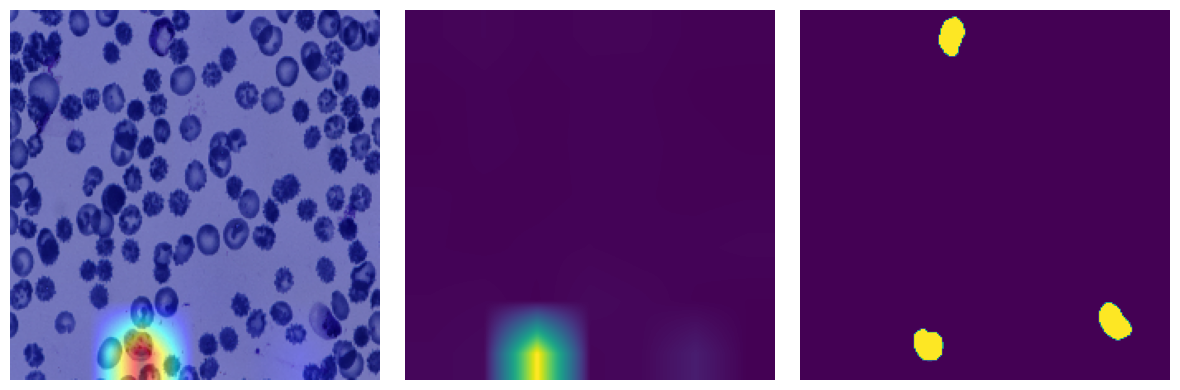

AUC Judd:  0.816791805
AUPRC:0.141446053981781


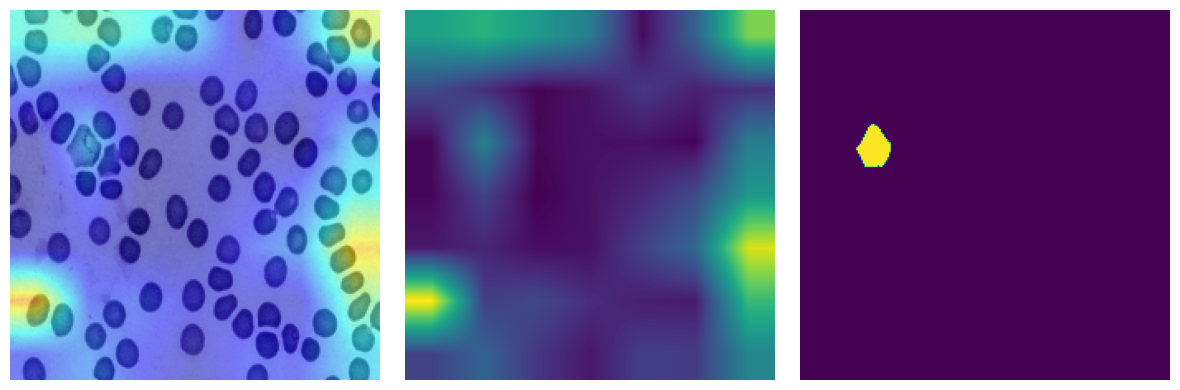

AUC Judd:  0.74578778
AUPRC:0.013695498928427696


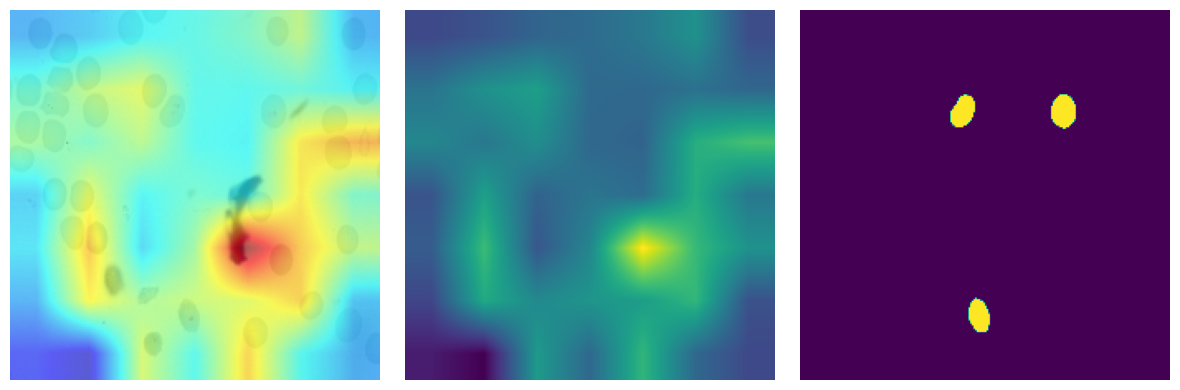

AUC Judd:  0.538384725
AUPRC:0.01422638725489378


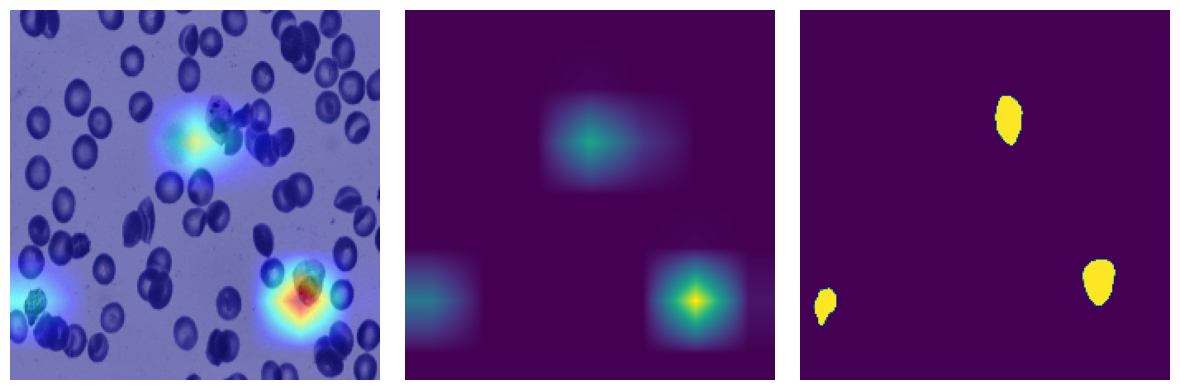

AUC Judd:  0.9600597750000001
AUPRC:0.2608451843261719


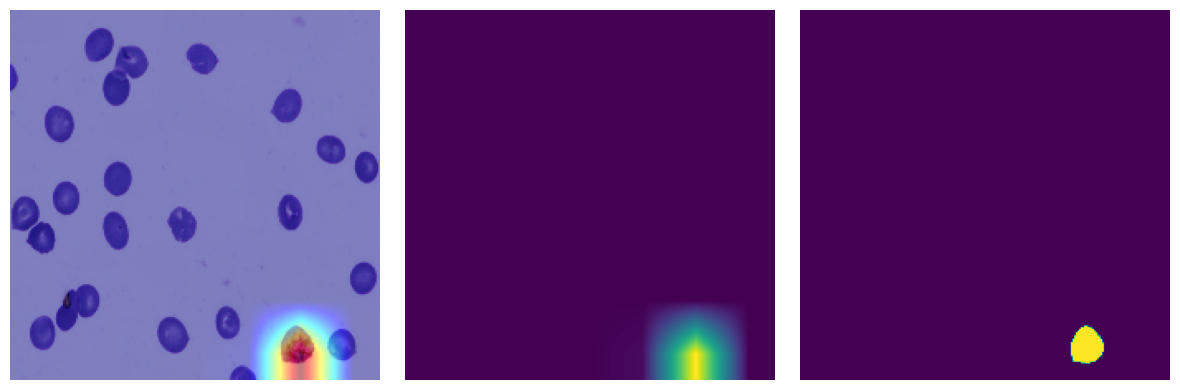

AUC Judd:  0.995096245
AUPRC:0.41830959916114807


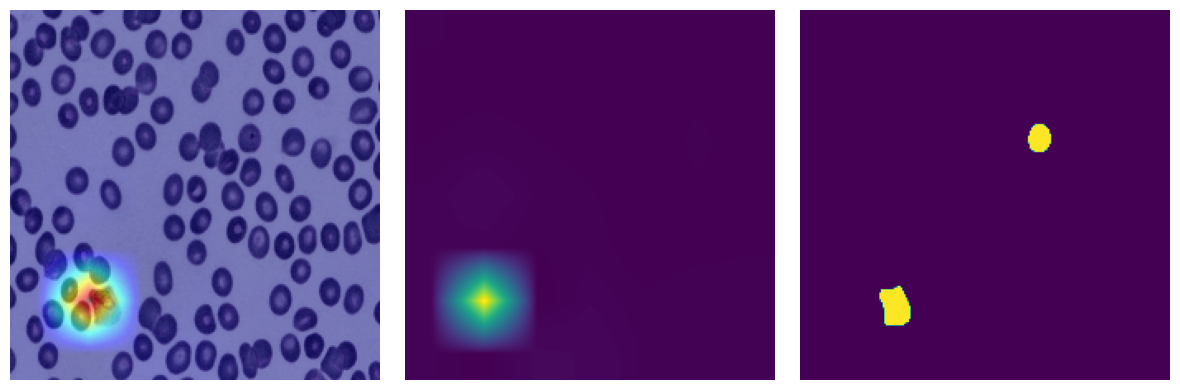

AUC Judd:  0.651977
AUPRC:0.2218252718448639


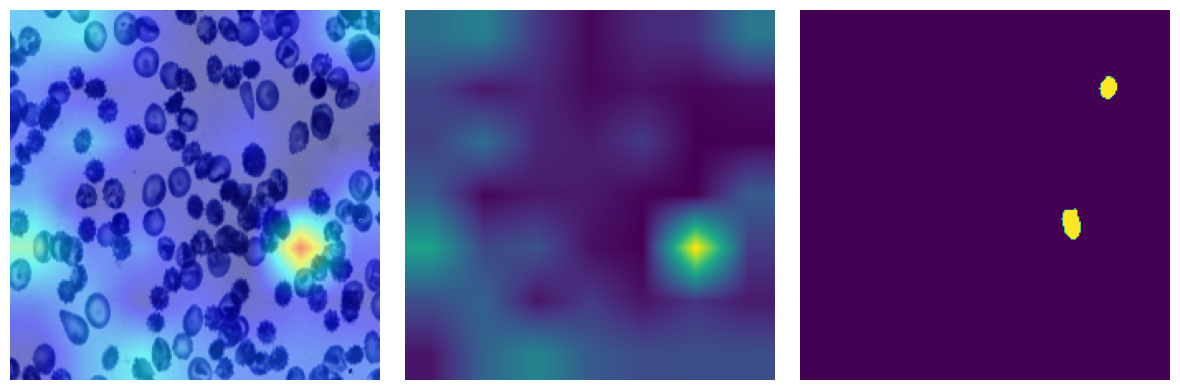

AUC Judd:  0.5414551950000001
AUPRC:0.010907814837992191


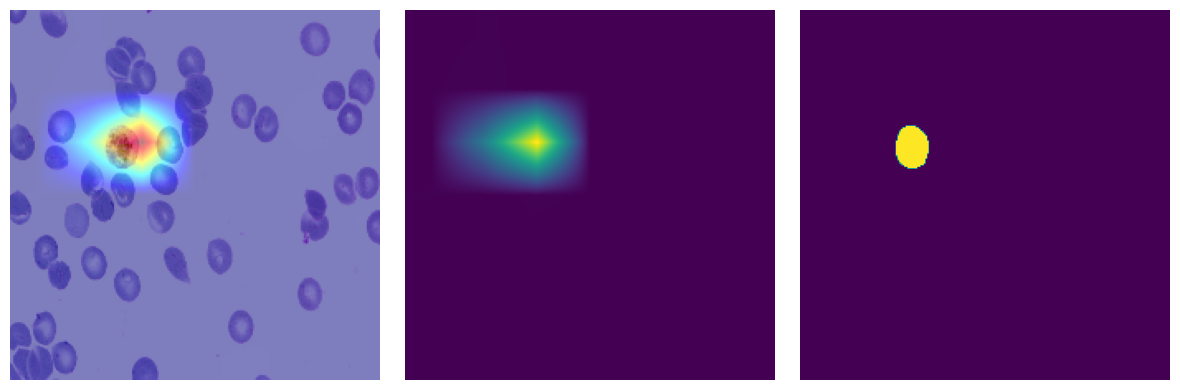

AUC Judd:  0.9940336900000001
AUPRC:0.4210420250892639


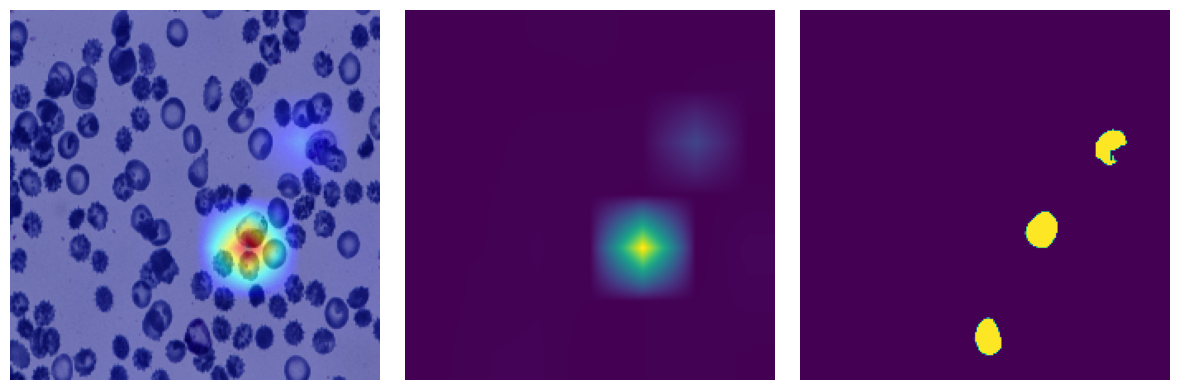

AUC Judd:  0.6996454000000002
AUPRC:0.1763405054807663


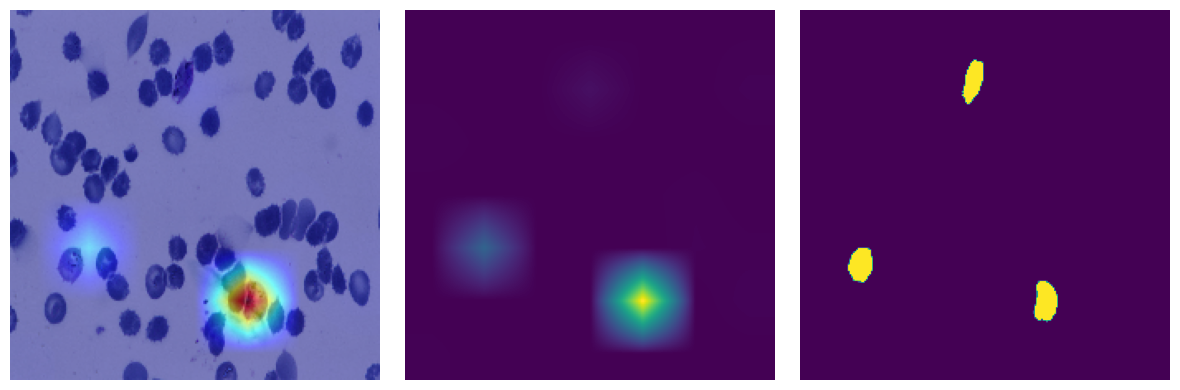

AUC Judd:  0.94087816
AUPRC:0.3045521378517151


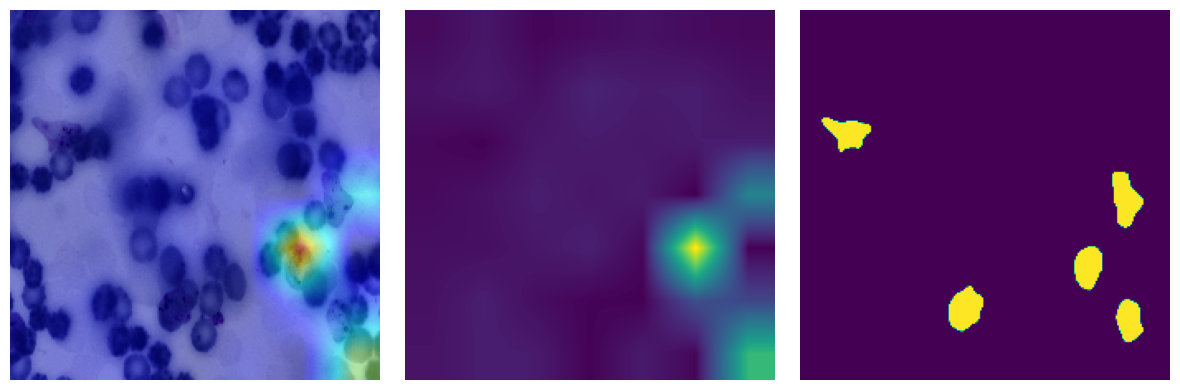

AUC Judd:  0.59000187
AUPRC:0.16052557528018951


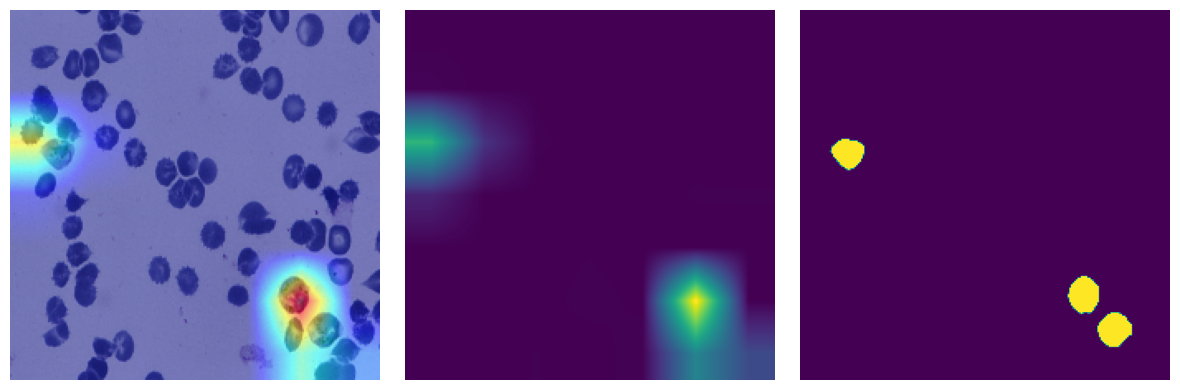

AUC Judd:  0.9751141299999999
AUPRC:0.4166871905326843


In [46]:
for data, datatype in malaria_data_in_malaria_sam[:25]:
  model_ft.eval()

  imgtransform = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  SAMimage = iptimage=Image.open(f"/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/malaria_SAM/{data}")
  iptimage=Image.open(f"/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/{datatype}/Malaria/{data}").convert('RGB')
  img_np = np.array(iptimage)
  img_resized = cv2.resize(img_np, (224, 224))
  img_np = np.array(img_resized).astype(np.float32) / 255.0

  input_tensor = imgtransform(iptimage)
  input_tensor = input_tensor.unsqueeze(0) #add batch dimension
  target_layers = [model_ft.features[-1]]


  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=model_ft, target_layers=target_layers, use_cuda=True)
  grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True)
  grayscale_cam = grayscale_cam[0, :]



  visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
  Image.fromarray(visualization)
  Image.fromarray(img_resized)

  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  samimg = cv2.resize(np.array(SAMimage),(224,224))

  gt = samimg
  gt = np.where(gt > 1, 1, gt)
  
  gc_tensor = torch.tensor(grayscale_cam.flatten())
  gt_tensor = torch.tensor(gt.flatten())

  auprc = binary_auprc(gc_tensor, gt_tensor)

  pr_curve = PrecisionRecallCurve(task="binary")
  precision, recall, thresholds = pr_curve(gc_tensor, gt_tensor)

  #DISPLAY STUFF
  # Display the first image
  axes[0].imshow(visualization)
  axes[0].axis('off')

  # Display the second image
  axes[1].imshow(grayscale_cam)
  axes[1].axis('off')

  # Display the third image
  axes[2].imshow(samimg)
  axes[2].axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the figure
  plt.show()
  auc_judd(gt, grayscale_cam)
  print(f"AUPRC:{auprc.item()}")
